In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import warnings
#Import Prophet model
from prophet import Prophet

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
# Data source: https://www.kaggle.com/datasets/sushobhitlutade/inventorysupply-chain-managementscm-superstore/data?select=Brand.csv
# US holiday 2004-2021 data: https://www.kaggle.com/datasets/donnetew/us-holiday-dates-2004-2021?select=US+Holiday+Dates+%282004-2021%29.csv

In [ ]:
#download data
# https://drive.google.com/file/d/1zLUFEgysYJIL0oAA7WIiv0eogs8xUel7/view?usp=sharing
# https://drive.google.com/file/d/1gevzcsdgYnpcMVUJBhOe3z6QsIPK7GJZ/view?usp=sharing

dwn_url='https://drive.google.com/uc?id='
# df_id = dwn_url+"1zLUFEgysYJIL0oAA7WIiv0eogs8xUel7"
df_trans = pd.read_csv(dwn_url+"1zLUFEgysYJIL0oAA7WIiv0eogs8xUel7") #transactions data
df_prod = pd.read_csv(dwn_url+"1gevzcsdgYnpcMVUJBhOe3z6QsIPK7GJZ") #products data

#deletes white spaces on column tittles
df_trans.columns = [col.strip() for col in df_trans.columns]
df_prod.columns = [col.strip() for col in df_prod.columns]

#transforms date column to datetime format
df_trans["Transaction_date"] = pd.to_datetime(df_trans["Transaction_date"], format = "%Y-%m-%d")

#Clean transaction table, delete unnecessary columns (Payment_Method, Customer_Cart, Cashier)
df_trans = df_trans.drop(columns=['Payment_Method', 'CustomerCart_CustomerID','Cashier_CashierID'])

#Clean data to show only 2014-2017 data
df_trans=df_trans[df_trans["Transaction_date"].dt.year <= 2017]


In [ ]:
#create column for Units Sold
df_trans['Units_Sold'] = df_trans['Quantity']

#delete column named 'Quantity' for better column lableling/understanding
df_trans = df_trans.drop(columns=['Quantity'])

#add columns to Transaction Table
df_trans['Cat-SubCat_ID']= df_trans['Products_ProductID'].str[:6]
df_trans['Cat_ID']= df_trans['Products_ProductID'].str[:3] #first 3 letters of Category ID
df_trans['SubCat_ID']= df_trans['Products_ProductID'].str[4:6] #first 2 letters of SubCategory ID
df_trans['Quarter'] = df_trans['Transaction_date'].dt.quarter
df_trans['Year']= df_trans['Transaction_date'].dt.year
df_trans['Month']= df_trans['Transaction_date'].dt.month
df_trans['Day_of_Year']= df_trans['Transaction_date'].dt.day_of_year
df_trans['Year-Month'] = df_trans['Transaction_date'].dt.to_period('M')
df_trans['Day_of_the_Week']= df_trans['Transaction_date'].dt.day_name()


In [ ]:
df_trans

,Transaction_date,Subtotal,Taxes,DiscountPrice,TotalAmount,Products_ProductID,Units_Sold,Cat-SubCat_ID,Cat_ID,SubCat_ID,Quarter,Year,Month,Day_of_Year,Year-Month,Day_of_the_Week
0,2016-11-11,261.96,11.46,78.59,273.42,FUR-BO-10001798,2,FUR-BO,FUR,BO,4,2016,11,316,2016-11,Friday
1,2016-11-11,512.36,22.42,153.71,534.77,FUR-CH-10000454,3,FUR-CH,FUR,CH,4,2016,11,316,2016-11,Friday
2,2016-06-16,14.62,0.91,0.00,15.53,OFF-LA-10000240,2,OFF-LA,OFF,LA,2,2016,6,168,2016-06,Thursday
3,2015-10-18,957.58,41.89,287.27,999.47,FUR-TA-10000577,5,FUR-TA,FUR,TA,4,2015,10,291,2015-10,Sunday
4,2015-10-18,27.96,1.57,2.80,29.53,OFF-ST-10000760,2,OFF-ST,OFF,ST,4,2015,10,291,2015-10,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,2014-01-23,75.74,4.26,7.57,80.00,FUR-FU-10001889,3,FUR-FU,FUR,FU,1,2014,1,23,2014-01,Thursday
9990,2017-03-03,91.96,5.17,9.20,97.13,FUR-FU-10000747,2,FUR-FU,FUR,FU,1,2017,3,62,2017-03,Friday
9991,2017-03-03,323.22,14.14,96.97,337.36,TEC-PH-10003645,2,TEC-PH,TEC,PH,1,2017,3,62,2017-03,Friday
9992,2017-03-03,71.04,4.00,7.10,75.04,OFF-PA-10004041,4,OFF-PA,OFF,PA,1,2017,3,62,2017-03,Friday


In [ ]:
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9952 entries, 0 to 9993
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Transaction_date    9952 non-null   datetime64[ns]
 1   Subtotal            9952 non-null   float64       
 2   Taxes               9952 non-null   float64       
 3   DiscountPrice       9952 non-null   float64       
 4   TotalAmount         9952 non-null   float64       
 5   Products_ProductID  9952 non-null   object        
 6   Units_Sold          9952 non-null   int64         
 7   Cat-SubCat_ID       9952 non-null   object        
 8   Cat_ID              9952 non-null   object        
 9   SubCat_ID           9952 non-null   object        
 10  Quarter             9952 non-null   int32         
 11  Year                9952 non-null   int32         
 12  Month               9952 non-null   int32         
 13  Day_of_Year         9952 non-null   int32         
 1

In [ ]:
#Groupby to create dataframe of items sold per year
items_per_year = df_trans.groupby(['Products_ProductID','Cat-SubCat_ID','Cat_ID','Year']).Units_Sold.sum().reset_index()
#create column that counts the instances of the item in the DataFrame - counts the number of years the product was sold (between 2014-2017)
items_per_year['No. Years sold'] = items_per_year.groupby(['Products_ProductID']).transform('size')

items_per_year

,Products_ProductID,Cat-SubCat_ID,Cat_ID,Year,Units_Sold,No. Years sold
0,FUR-BO-10000112,FUR-BO,FUR,2017,9,1
1,FUR-BO-10000330,FUR-BO,FUR,2014,4,3
2,FUR-BO-10000330,FUR-BO,FUR,2015,4,3
3,FUR-BO-10000330,FUR-BO,FUR,2017,2,3
4,FUR-BO-10000362,FUR-BO,FUR,2014,8,3
...,...,...,...,...,...,...
5347,TEC-PH-10004959,TEC-PH,TEC,2015,1,2
5348,TEC-PH-10004977,TEC-PH,TEC,2014,6,4
5349,TEC-PH-10004977,TEC-PH,TEC,2015,2,4
5350,TEC-PH-10004977,TEC-PH,TEC,2016,7,4


In [ ]:
subcat_per_year = df_trans.groupby(['Cat-SubCat_ID','Year']).Units_Sold.sum().reset_index()
#subcat_per_year['No. Years sold'] = items_per_year.groupby(['Cat-SubCat_ID']).transform('size')

subcat_per_year.sort_values(['Units_Sold'], ascending=False).head(50).reset_index().head()

,index,Cat-SubCat_ID,Year,Units_Sold
0,27,OFF-BI,2017,2051
1,43,OFF-PA,2017,1706
2,26,OFF-BI,2016,1615
3,42,OFF-PA,2016,1363
4,25,OFF-BI,2015,1195


In [ ]:
Items_all_4_years = items_per_year[items_per_year['No. Years sold']== 4]
Items_all_4_years

,Products_ProductID,Cat-SubCat_ID,Cat_ID,Year,Units_Sold,No. Years sold
7,FUR-BO-10000468,FUR-BO,FUR,2014,4,4
8,FUR-BO-10000468,FUR-BO,FUR,2015,4,4
9,FUR-BO-10000468,FUR-BO,FUR,2016,1,4
10,FUR-BO-10000468,FUR-BO,FUR,2017,12,4
15,FUR-BO-10001337,FUR-BO,FUR,2014,14,4
...,...,...,...,...,...,...
5337,TEC-PH-10004908,TEC-PH,TEC,2017,1,4
5348,TEC-PH-10004977,TEC-PH,TEC,2014,6,4
5349,TEC-PH-10004977,TEC-PH,TEC,2015,2,4
5350,TEC-PH-10004977,TEC-PH,TEC,2016,7,4


In [ ]:
Items_all_4_years.sort_values(['Units_Sold'], ascending=False)


,Products_ProductID,Cat-SubCat_ID,Cat_ID,Year,Units_Sold,No. Years sold
4627,TEC-AC-10003832,TEC-AC,TEC,2016,41,4
424,FUR-FU-10000023,FUR-FU,FUR,2017,31,4
2522,OFF-BI-10004728,OFF-BI,OFF,2016,30,4
3469,OFF-PA-10002377,OFF-PA,OFF,2017,30,4
1891,OFF-BI-10000301,OFF-BI,OFF,2017,29,4
...,...,...,...,...,...,...
3527,OFF-PA-10002893,OFF-PA,OFF,2017,1,4
2625,OFF-EN-10002504,OFF-EN,OFF,2015,1,4
2916,OFF-LA-10001771,OFF-LA,OFF,2016,1,4
994,FUR-TA-10001768,FUR-TA,FUR,2017,1,4


In [ ]:
Items_3_to_4_years = items_per_year[items_per_year['No. Years sold']>= 3]
Items_3_to_4_years

,Products_ProductID,Cat-SubCat_ID,Cat_ID,Year,Units_Sold,No. Years sold
1,FUR-BO-10000330,FUR-BO,FUR,2014,4,3
2,FUR-BO-10000330,FUR-BO,FUR,2015,4,3
3,FUR-BO-10000330,FUR-BO,FUR,2017,2,3
4,FUR-BO-10000362,FUR-BO,FUR,2014,8,3
5,FUR-BO-10000362,FUR-BO,FUR,2015,5,3
...,...,...,...,...,...,...
5343,TEC-PH-10004922,TEC-PH,TEC,2017,3,3
5348,TEC-PH-10004977,TEC-PH,TEC,2014,6,4
5349,TEC-PH-10004977,TEC-PH,TEC,2015,2,4
5350,TEC-PH-10004977,TEC-PH,TEC,2016,7,4


interactive(children=(Dropdown(description='categories', options=('FUR-BO', 'FUR-CH', 'OFF-LA', 'FUR-TA', 'OFF…

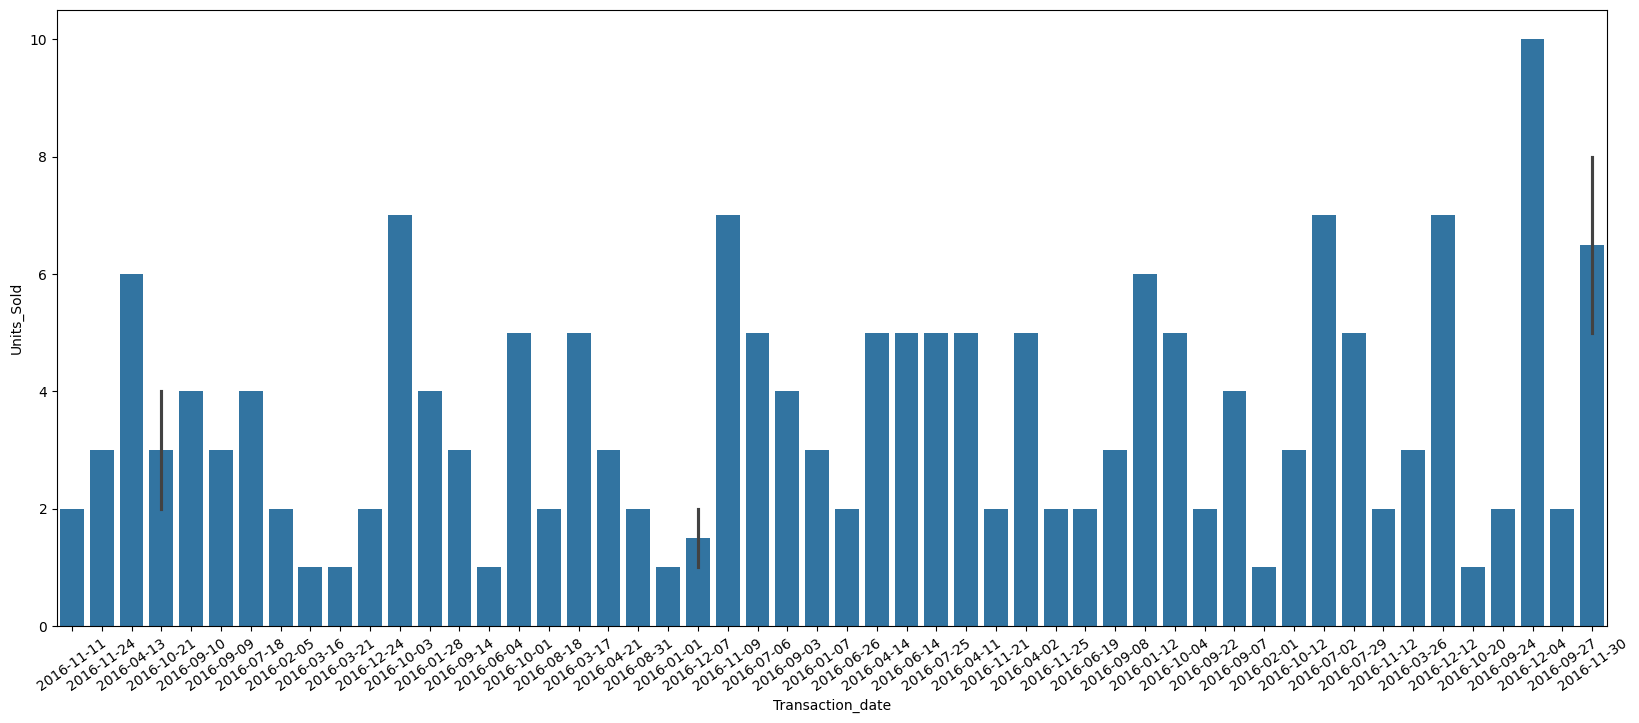

In [ ]:
@interact
def scatter_plot(categories = df_trans['Cat-SubCat_ID'].unique(), year = df_trans['Year'].unique()):
    cond1 = df_trans['Cat-SubCat_ID'] == categories
    cond2 = df_trans['Year'] == year

    plt.figure(figsize=(20, 8))
    sns.barplot(
    data= df_trans[cond1][cond2],
    x = 'Transaction_date',
    y = 'Units_Sold'
    );
    plt.tick_params(axis='x', rotation=35);

interactive(children=(Dropdown(description='categories', options=('FUR', 'OFF', 'TEC'), value='FUR'), Output()…

<Figure size 4000x800 with 0 Axes>

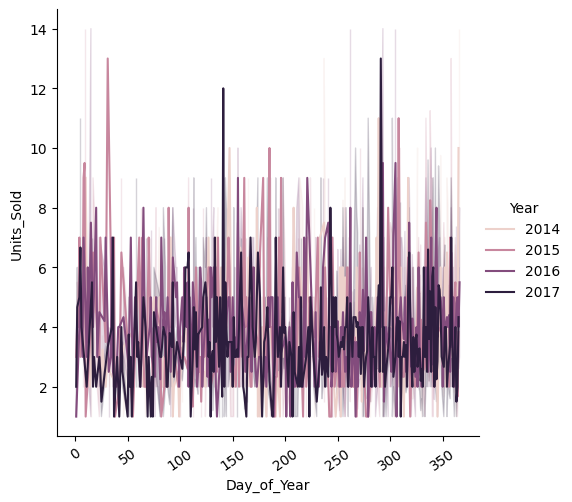

<Figure size 4000x800 with 0 Axes>

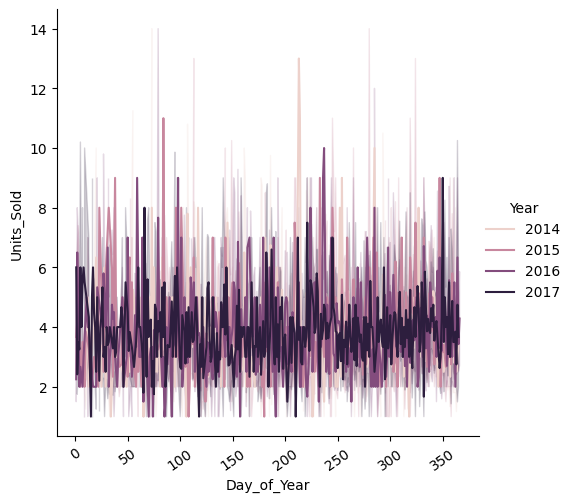

<Figure size 4000x800 with 0 Axes>

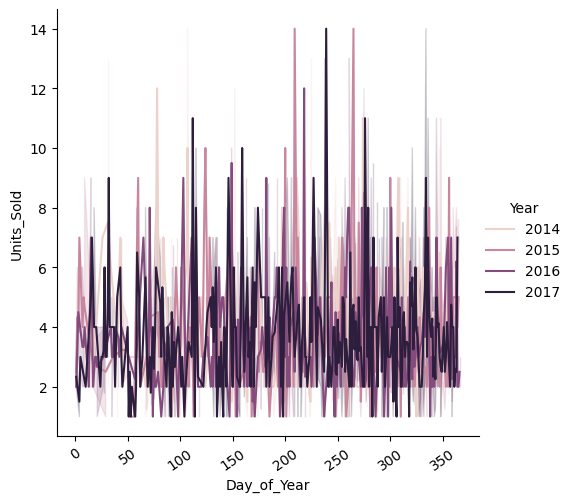

In [ ]:
@interact
def scatter_plot(categories = df_trans['Cat_ID'].unique()):
    cond1 = df_trans['Cat_ID'] == categories
    #cond2 = df_trans['Year'] == year

    plt.figure(figsize=(40, 8))
    sns.relplot(
    data= df_trans[cond1],
    kind='line',
    x = 'Day_of_Year',
    y = 'Units_Sold',
    hue= 'Year',
    #ax = axes[1]
    );
    plt.tick_params(axis='x', rotation=35);

In [ ]:
# Instead of one item, we choose one sub-catagory 'OFF-BI'.

# df_subcat = df_trans.query("'Cat-SubCat_ID' == 'OFF-BI'").sort_values(["Transaction_date"], axis=0, ascending=[True])

df_OFF_BI = df_trans.query("`Cat-SubCat_ID` == 'OFF-BI'")
#df_OFF_BI = df_OFF_BI.sort_values(['Transaction_date'], axis=0, ascending=[True])
#df_OFF_BI = df_OFF_BI.groupby(["Transaction_date"]).Units_Sold.sum()
df_OFF_BI_M = df_OFF_BI.groupby(pd.Grouper(key="Transaction_date", freq='M'))[['Units_Sold']].sum().reset_index()
df_OFF_BI_M = df_OFF_BI_M.rename(columns={"Transaction_date":"Month",'Units_Sold':'Units_Sold_Monthly'})
#df_OFF_BI_W = df_OFF_BI.groupby(pd.Grouper(key="Transaction_date", freq='SM'))[['Units_Sold']].sum().reset_index()
#df_OFF_BI_W = df_OFF_BI_W.rename(columns={"Transaction_date":"Bi-Week",'Units_Sold':'Units_Sold_Bi-Weekly'})

df_OFF_BI_M.head()



,Month,Units_Sold_Monthly
0,2014-01-31,41
1,2014-02-28,38
2,2014-03-31,77
3,2014-04-30,78
4,2014-05-31,93


In [ ]:
df_OFF_BI_M_copy = df_OFF_BI_M.rename(columns={'Month': 'ds', 'Units_Sold_Monthly': 'y'})
df_OFF_BI_M_plot = df_OFF_BI_M_copy.set_index('ds')
df_OFF_BI_M_plot.head()

,y
ds,
2014-01-31,41
2014-02-28,38
2014-03-31,77
2014-04-30,78
2014-05-31,93


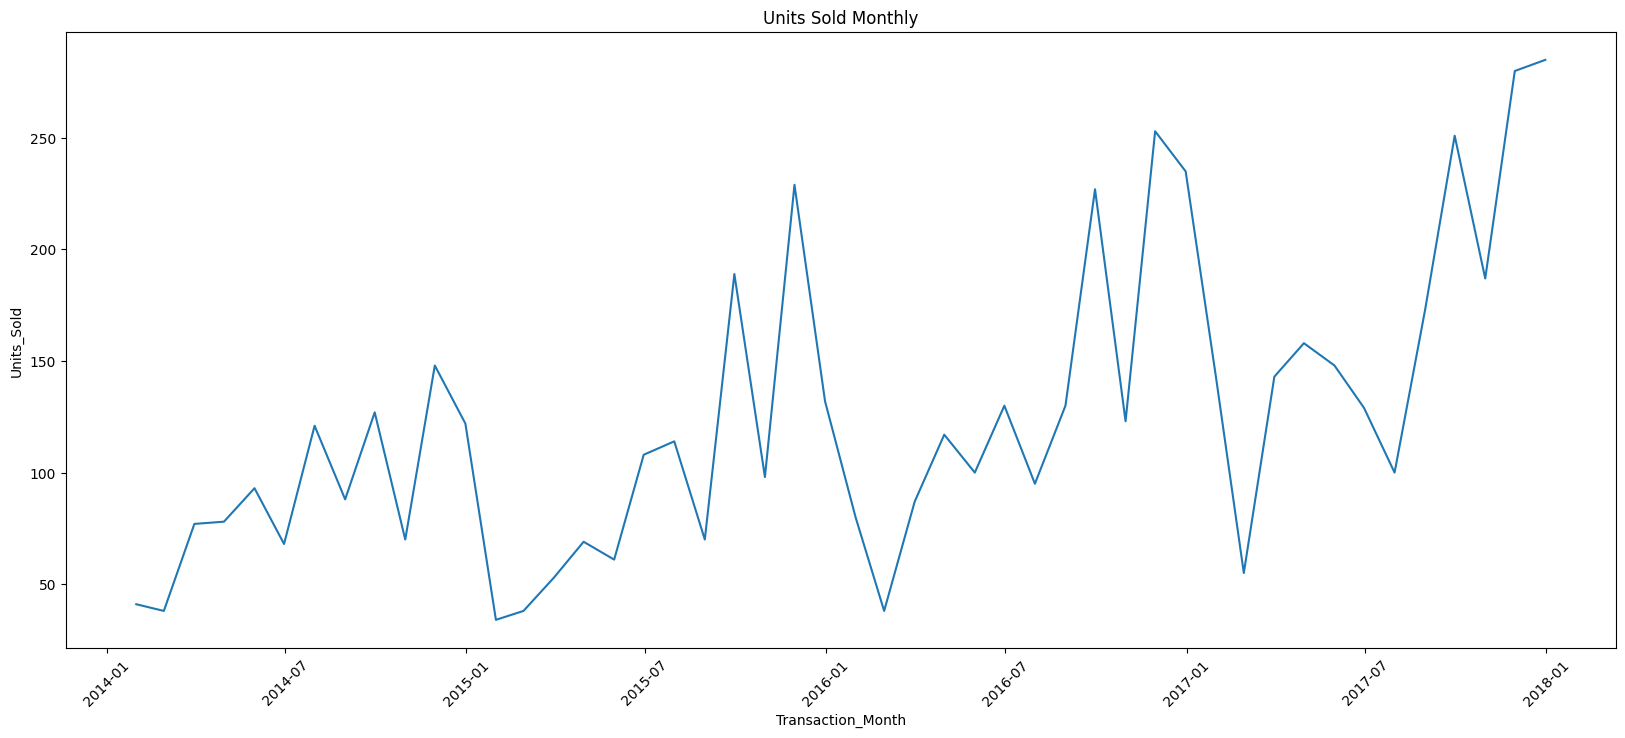

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(df_OFF_BI_M_plot)
plt.ylabel('Units_Sold')
plt.xlabel('Transaction_Month')
plt.xticks(rotation=45)
plt.title('Units Sold Monthly')
plt.show()

In [ ]:
df_OFF_BI_BW = df_OFF_BI.groupby(pd.Grouper(key="Transaction_date", freq='SM'))[['Units_Sold']].sum().reset_index()
df_OFF_BI_BW = df_OFF_BI_W.rename(columns={"Transaction_date":"Bi-Week",'Units_Sold':'Units_Sold_Bi-Weekly'})

In [ ]:
df_OFF_BI_BW_copy = df_OFF_BI_BW.rename(columns={'Bi-Week': 'ds', 'Units_Sold_Bi-Weekly': 'y'})
df_OFF_BI_BW_plot = df_OFF_BI_BW_copy.set_index('ds')
df_OFF_BI_BW_plot.head()

,y
ds,
2013-12-31,11
2014-01-15,30
2014-01-31,15
2014-02-15,23
2014-02-28,16


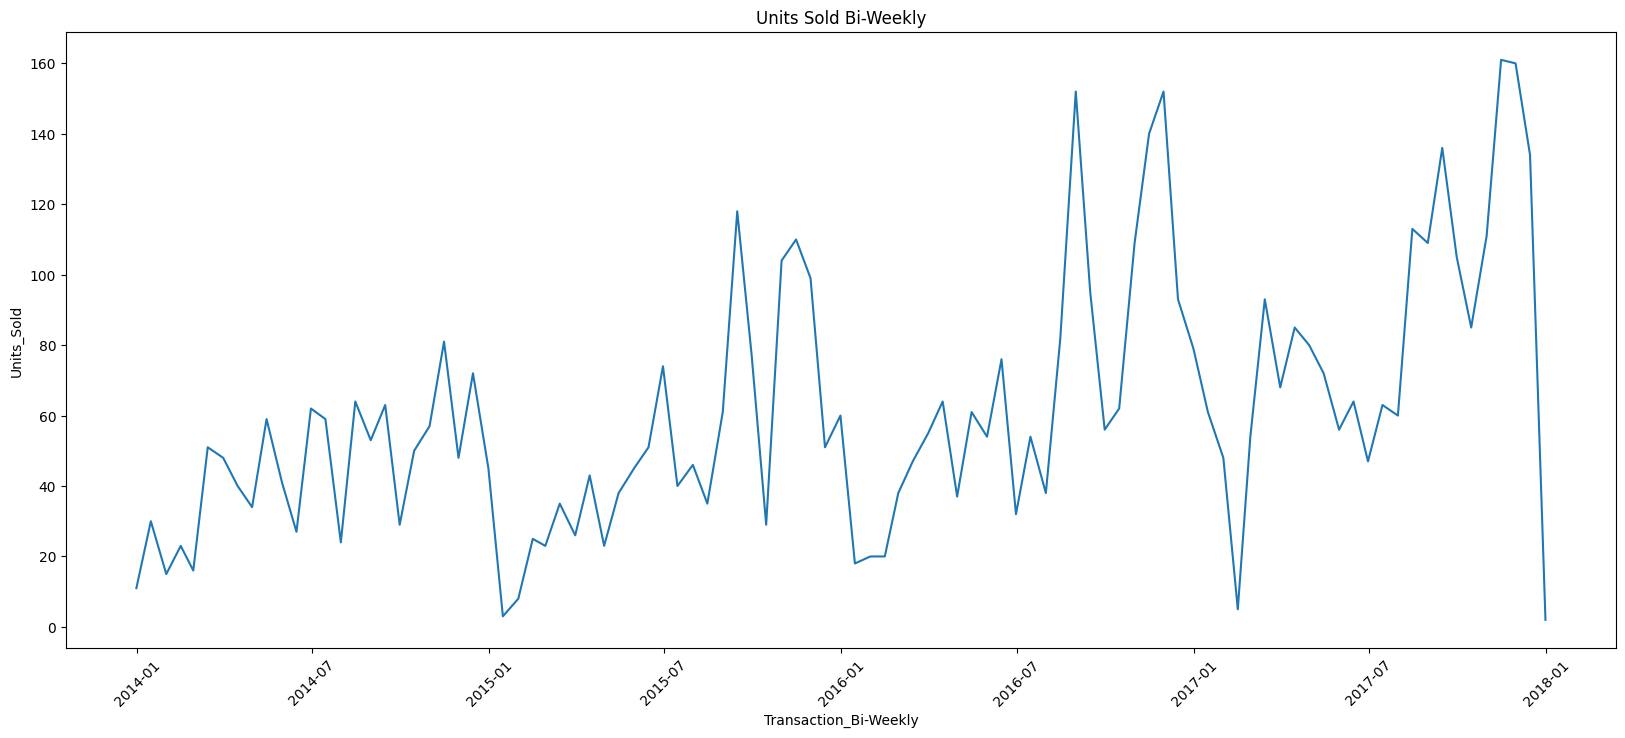

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(df_OFF_BI_BW_plot)
plt.ylabel('Units_Sold')
plt.xlabel('Transaction_Bi-Weekly')
plt.xticks(rotation=45)
plt.title('Units Sold Bi-Weekly')
plt.show()

In [ ]:
df_OFF_BI_W = df_OFF_BI.groupby(pd.Grouper(key="Transaction_date", freq='W'))[['Units_Sold']].sum().reset_index()
df_OFF_BI_W = df_OFF_BI_W.rename(columns={"Transaction_date":"Week",'Units_Sold':'Units_Sold_Weekly'})

In [ ]:
df_OFF_BI_W_copy = df_OFF_BI_W.rename(columns={'Week': 'ds', 'Units_Sold_Weekly': 'y'})
df_OFF_BI_W_plot = df_OFF_BI_W_copy.set_index('ds')
df_OFF_BI_W_plot.head()

,y
ds,
2014-01-12,11
2014-01-19,7
2014-01-26,21
2014-02-02,2
2014-02-09,13


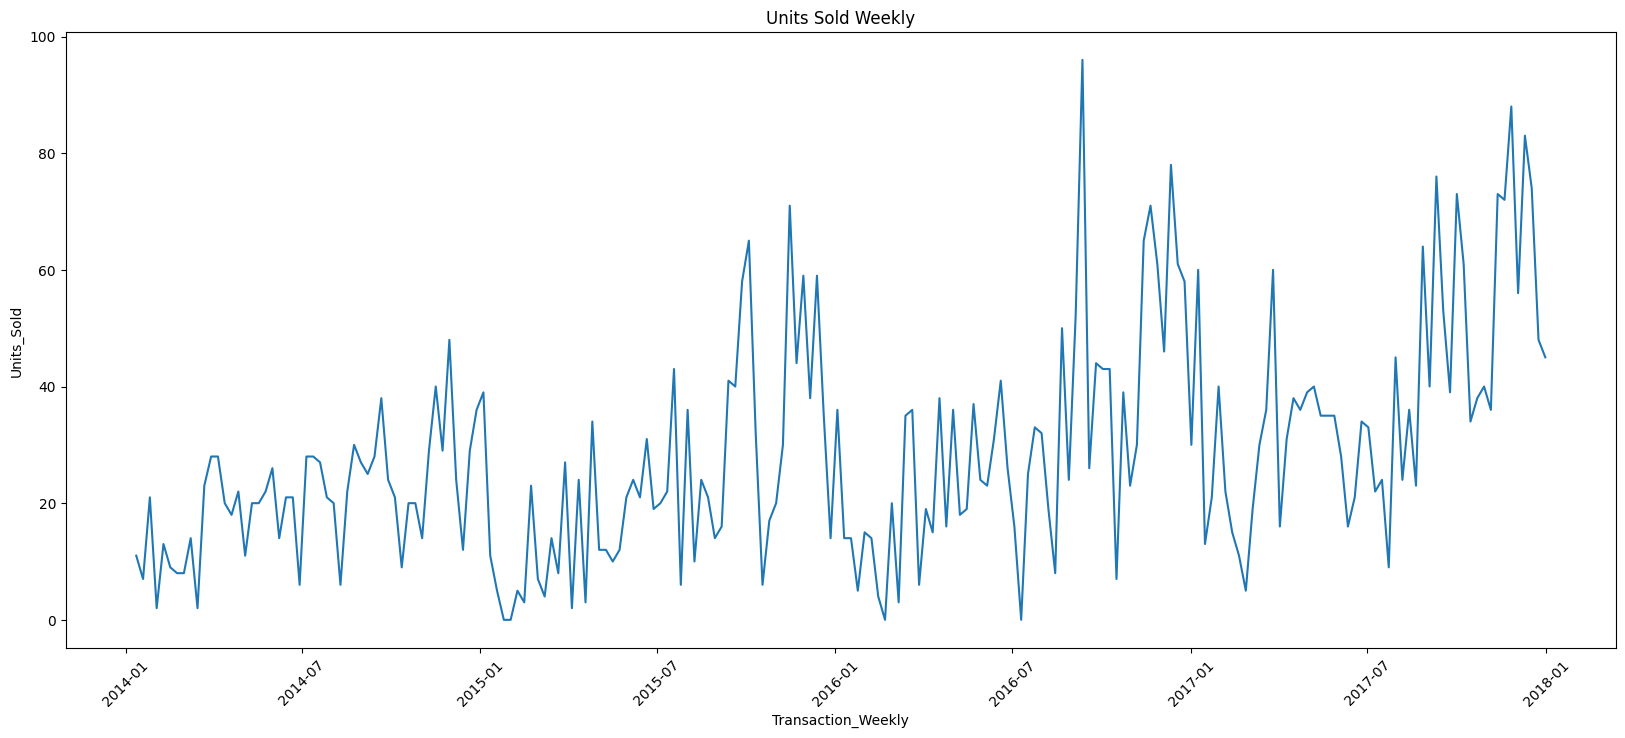

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(df_OFF_BI_W_plot)
plt.ylabel('Units_Sold')
plt.xlabel('Transaction_Weekly')
plt.xticks(rotation=45)
plt.title('Units Sold Weekly')
plt.show()

In [ ]:
from datetime import date
#Variables
forecast_start_dt = date(2017,5,31) #data set ends of (2017,5,31)
forecast_start_date = (forecast_start_dt).strftime("%Y-%m-%d")
print(forecast_start_date)

2017-05-31


In [ ]:
#PROPHET MODEL - Units Sold Monthly

train_set = df_OFF_BI_M_copy[df_OFF_BI_M_copy['ds'] < forecast_start_date]

model = Prophet(seasonality_mode='multiplicative').fit(train_set)

future = model.make_future_dataframe(periods=365 ,freq='M')
fcst_prophet_train = model.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date
predicted_df = fcst_prophet_train[filter][['ds','yhat']]


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7ag3z_8/wipa9oi7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7ag3z_8/26g5e_rg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94294', 'data', 'file=/tmp/tmpg7ag3z_8/wipa9oi7.json', 'init=/tmp/tmpg7ag3z_8/26g5e_rg.json', 'output', 'file=/tmp/tmpg7ag3z_8/prophet_modelphqjmadz/prophet_model-20240718203555.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:35:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:35:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
predicted_df.head(5)

,ds,yhat,ytrue
0,2017-05-31,131.458711,148
1,2017-06-30,162.757389,129
2,2017-07-31,156.000940,100
3,2017-08-31,154.420160,173
4,2017-09-30,281.000177,251


In [ ]:
df_OFF_BI_M_comp = df_OFF_BI_M_copy
df_OFF_BI_M_comp.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_OFF_BI_M_comp)
predicted_df.head()

,ds,yhat,ytrue
0,2017-05-31,131.458711,148
1,2017-06-30,162.757389,129
2,2017-07-31,156.000940,100
3,2017-08-31,154.420160,173
4,2017-09-30,281.000177,251


In [ ]:
def mape(actual, pred):
    '''
    Mean Absolute Percentage Error (MAPE) Function

    input: list/series for actual values and predicted values
    output: mape value
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
mape(predicted_df['ytrue'], predicted_df['yhat'])

19.80942117343818

In [ ]:
future = model.make_future_dataframe(periods=12, freq='MS')
future.tail()

,ds
47,2017-12-01
48,2018-01-01
49,2018-02-01
50,2018-03-01
51,2018-04-01


In [ ]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
47,2017-12-01,242.844840,223.899786,259.257798
48,2018-01-01,332.457055,316.128324,352.230410
49,2018-02-01,190.480929,174.120922,207.939260
50,2018-03-01,0.593380,-17.757426,17.269542
51,2018-04-01,141.754566,124.089651,160.631145


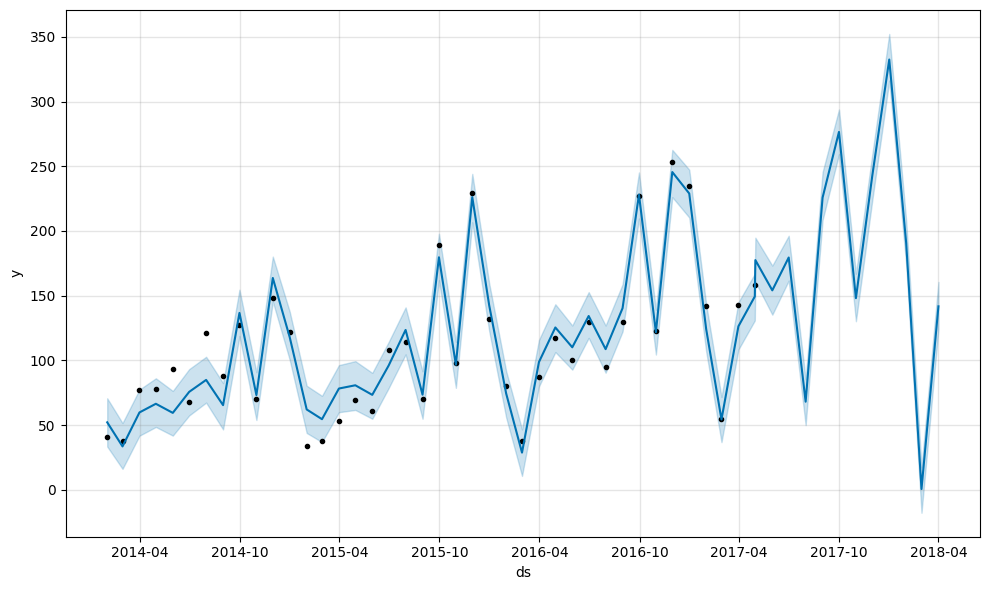

In [ ]:
fig1 = model.plot(forecast)

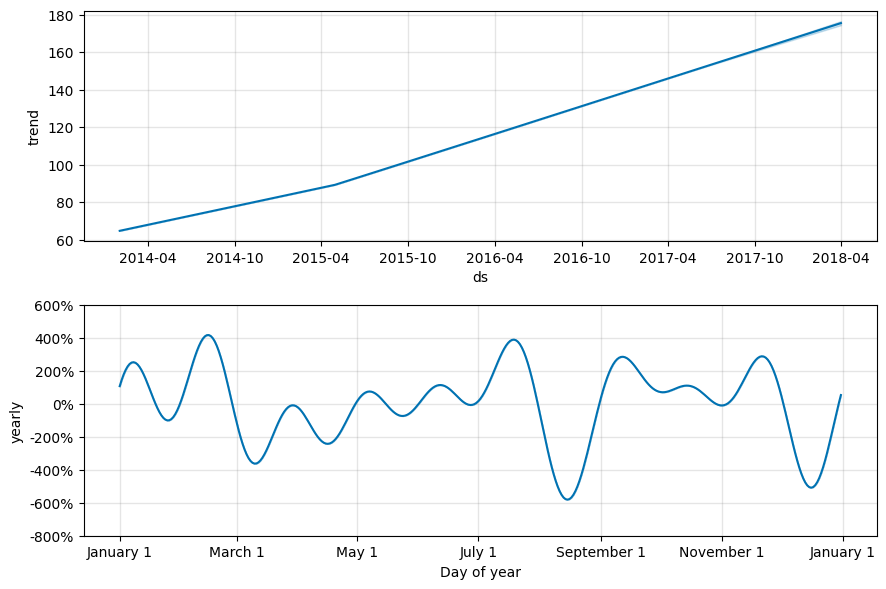

In [ ]:
fig2 = model.plot_components(forecast)

In [ ]:
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='30 days', horizon = '60 days')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Making 14 forecasts with cutoffs between 2016-02-05 00:00:00 and 2017-03-01 00:00:00


  0%|          | 0/14 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7ag3z_8/uhlb3ujx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7ag3z_8/3twet0xd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23874', 'data', 'file=/tmp/tmpg7ag3z_8/uhlb3ujx.json', 'init=/tmp/tmpg7ag3z_8/3twet0xd.json', 'output', 'file=/tmp/tmpg7ag3z_8/prophet_modelz0smxzm_/prophet_model-20240718213637.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:36:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:36:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpg7ag3z_8/l6knpqj0.json
DEBUG:cmdstanpy:input tempfi

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,24 days,6122.573615,78.246876,70.633019,0.853637,0.853637,1.527383,0.0
1,25 days,747.165023,27.334320,27.303254,0.271676,0.271676,0.269276,0.0
2,26 days,14090.927997,118.705215,118.654698,1.045642,1.045642,1.251129,0.0
3,27 days,16237.316032,127.425728,127.120608,1.236434,1.183296,1.042002,0.0
4,28 days,3661.924051,60.513834,60.379643,0.371844,0.371844,0.340252,0.0


In [ ]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-02-29,1.035218,1.029659,1.042133,38,2016-02-05
1,2016-03-31,113.632773,111.751105,115.923226,87,2016-02-05
2,2016-04-30,92.916624,89.744344,96.282855,117,2016-02-05
3,2016-03-31,113.000438,110.901642,115.166332,87,2016-03-06
4,2016-04-30,90.855403,88.729375,92.914278,117,2016-03-06


In [ ]:
# https://drive.google.com/file/d/1wFQTKwfvLRoxL0Ky7K4Yd2-jxUKs0IwK/view?usp=sharing
dwn_url='https://drive.google.com/uc?id='
#df_id = dwn_url+"1wFQTKwfvLRoxL0Ky7K4Yd2-jxUKs0IwK"
df_holiday = pd.read_csv(
    dwn_url+"1wFQTKwfvLRoxL0Ky7K4Yd2-jxUKs0IwK"
)

In [ ]:
df_holiday

In [ ]:
df_holiday['Date'] = pd.to_datetime(df_holiday['Date'])

In [ ]:
df_holiday.info()

In [ ]:
start_date = '2014-01-01'
end_date = '2018-12-31'

df_hld = df_holiday[(df_holiday['Date'] >= start_date) & (df_holiday['Date'] <= end_date)]

In [ ]:
df_hld

In [ ]:
df_hld['Holiday'].value_counts()